TRAFFIC SIGN RECOGNITION

In [125]:
import numpy as np
import pandas as pd
import os
from PIL import Image
import random
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Flatten, BatchNormalization
from keras.applications import VGG16
from keras.optimizers import Adam
from PIL import Image
from keras.callbacks import LearningRateScheduler
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from keras.preprocessing.image import array_to_img
from io import StringIO

In [126]:
my_path = os.getcwd()

In [127]:
data = []
labels = []

In [128]:
def lr_schedule(epoch):
    if epoch < 5:
        return 0.0001
    else:
        return 0.00001

In [129]:
for i in range(43):
    path = os.path.join(my_path, 'Train', str(i))
    images = os.listdir(path)
    for a in images:
        try:
            image = Image.open(os.path.join(path, a))
            image = image.resize((32, 32))
            image = np.array(image)
            data.append([image, i])
        except FileNotFoundError:
            print(f"File not found: {os.path.join(path, a)}")
        except Exception as e:
            print(f"Error processing image: {os.path.join(path, a)} - {e}")

In [130]:
random.shuffle(data)

In [131]:
x = []
y = []

In [132]:
for features, label in data:
    x.append(features)
    y.append(label)

In [133]:
x = np.array(x)
y = np.array(y)

In [134]:
X_train, X_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

In [135]:
X_train = X_train / 255.0
X_val = X_val / 255.0

In [136]:
model = Sequential()
model.add(VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(43, activation='softmax'))
adam = Adam(learning_rate=0.0001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [137]:
lr_scheduler = LearningRateScheduler(lr_schedule)

In [138]:
history = model.fit(X_train, y_train, batch_size=128, epochs=10, validation_data=(X_val, y_val),
                    callbacks=[lr_scheduler])

Epoch 1/10
246/246 [==============================] - 285s 1s/step - loss: 0.6163 - accuracy: 0.8348 - val_loss: 0.5014 - val_accuracy: 0.9458 - lr: 1.0000e-04
Epoch 2/10
246/246 [==============================] - 294s 1s/step - loss: 0.0588 - accuracy: 0.9837 - val_loss: 0.0978 - val_accuracy: 0.9709 - lr: 1.0000e-04
Epoch 3/10
246/246 [==============================] - 286s 1s/step - loss: 0.0186 - accuracy: 0.9949 - val_loss: 0.0577 - val_accuracy: 0.9821 - lr: 1.0000e-04
Epoch 4/10
246/246 [==============================] - 289s 1s/step - loss: 0.0172 - accuracy: 0.9950 - val_loss: 0.0467 - val_accuracy: 0.9833 - lr: 1.0000e-04
Epoch 5/10
246/246 [==============================] - 300s 1s/step - loss: 0.0122 - accuracy: 0.9968 - val_loss: 0.0345 - val_accuracy: 0.9902 - lr: 1.0000e-04
Epoch 6/10
246/246 [==============================] - 297s 1s/step - loss: 0.0025 - accuracy: 0.9996 - val_loss: 0.0048 - val_accuracy: 0.9985 - lr: 1.0000e-05
Epoch 7/10
246/246 [====================

In [139]:
y_test = pd.read_csv('Test.csv')

In [140]:
labels = y_test["ClassId"].values
imgs = y_test["Path"].values

In [141]:
data = []

In [142]:
for img in imgs:
    image = Image.open(img)
    image = image.resize((32, 32))
    data.append(np.array(image))

In [143]:
X_test = np.array(data)
X_test = X_test / 255.0

In [144]:
pred = np.argmax(model.predict(X_test), axis=-1)

395/395 [==============================] - 23s 58ms/step


In [145]:
print(accuracy_score(labels, pred))
# Evaluate on test set
pred = np.argmax(model.predict(X_test), axis=-1)

0.9642913697545527
395/395 [==============================] - 22s 57ms/step


Print accuracy

In [146]:
accuracy = accuracy_score(labels, pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.9643


Print classification report

In [147]:
class_report = classification_report(labels, pred)
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.92      0.96        60
           1       0.97      1.00      0.98       720
           2       0.98      0.99      0.98       750
           3       0.98      0.94      0.96       450
           4       0.99      0.96      0.97       660
           5       0.95      0.97      0.96       630
           6       1.00      0.98      0.99       150
           7       0.99      0.92      0.95       450
           8       0.92      0.99      0.96       450
           9       0.99      0.98      0.99       480
          10       1.00      0.98      0.99       660
          11       0.88      0.95      0.92       420
          12       1.00      1.00      1.00       690
          13       0.99      1.00      1.00       720
          14       0.98      0.99      0.98       270
          15       1.00      0.99      1.00       210
          16       0.98      1.00      0.99       150
    

In [148]:
class_report_str = classification_report(labels, pred, output_dict=True)

class_report_df = pd.DataFrame(class_report_str).transpose()
class_report_df = class_report_df[class_report_df.index.str.isnumeric()]
class_report_df['class'] = class_report_df.index.astype(int)
class_report_df.set_index('class', inplace=True)


Plotting precision for each class

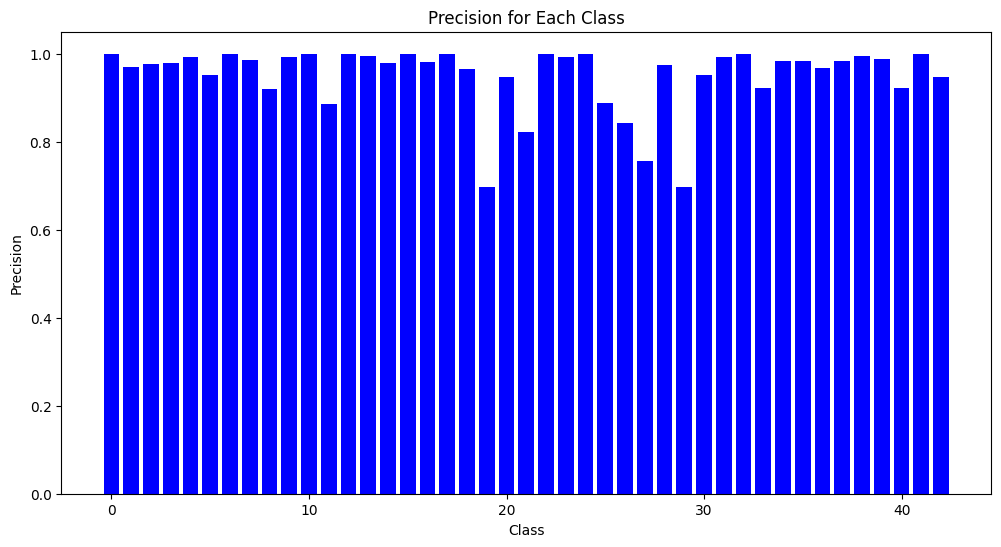

In [149]:
plt.figure(figsize=(12, 6))
plt.bar(class_report_df.index, class_report_df['precision'], color='blue')
plt.xlabel('Class')
plt.ylabel('Precision')
plt.title('Precision for Each Class')
plt.show()

Plotting recall for each class

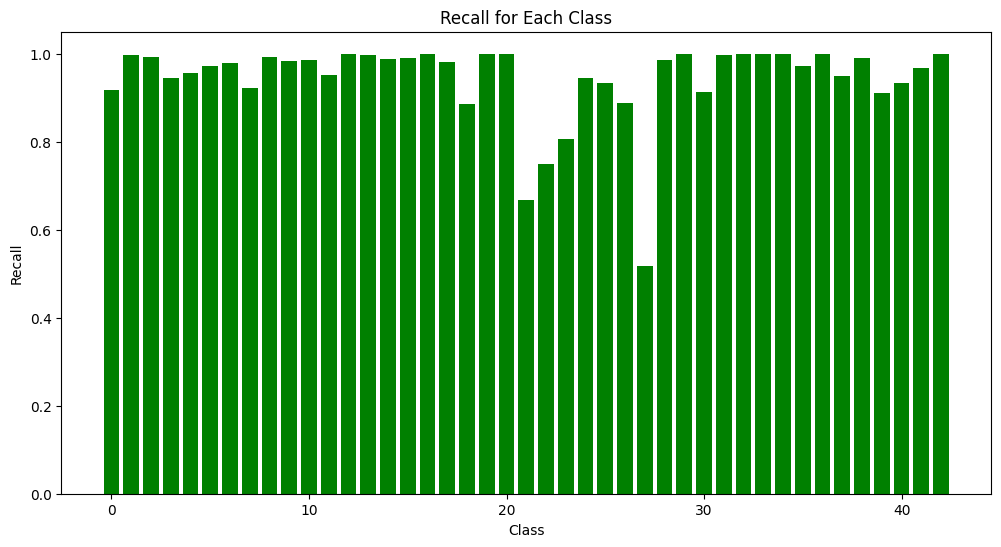

In [150]:
plt.figure(figsize=(12, 6))
plt.bar(class_report_df.index, class_report_df['recall'], color='green')
plt.xlabel('Class')
plt.ylabel('Recall')
plt.title('Recall for Each Class')
plt.show()

Plotting F1-score for each class

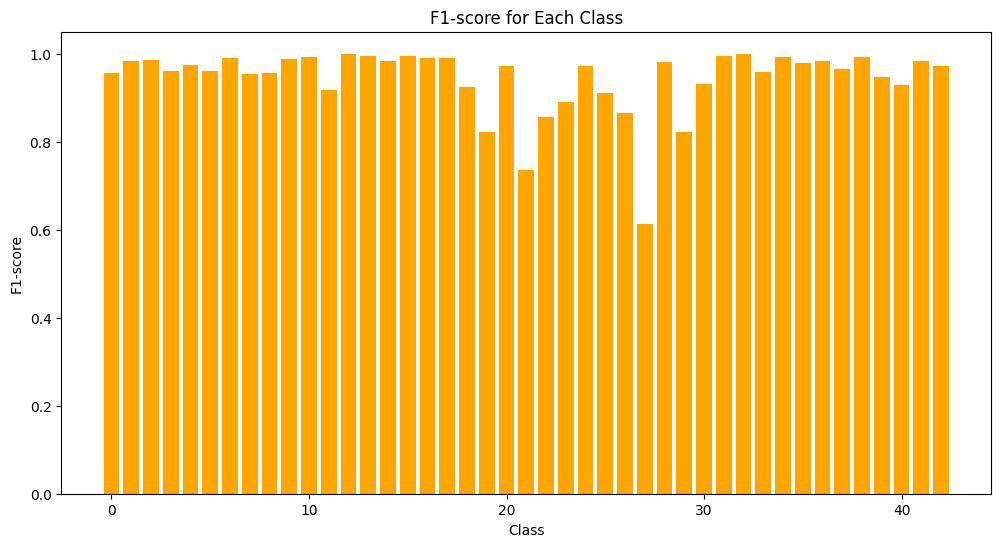

In [151]:
plt.figure(figsize=(12, 6))
plt.bar(class_report_df.index, class_report_df['f1-score'], color='orange')
plt.xlabel('Class')
plt.ylabel('F1-score')
plt.title('F1-score for Each Class')
plt.show()

In [152]:
incorrect_indices = np.where(pred != labels)[0]

num_samples = 3
num_cols = 5       

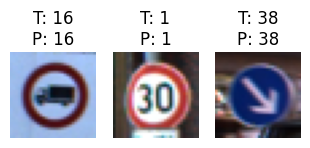

In [153]:
for i in range(min(num_samples, len(labels))):
    plt.subplot(1, num_cols, i % num_cols + 1)
    plt.imshow(array_to_img(X_test[i]))
    plt.title(f"T: {labels[i]}\nP: {pred[i]}")
    plt.axis('off')

    # If the last subplot in the row, create a new row
    if (i + 1) % num_cols == 0 or i == num_samples - 1:
        plt.show()

Display the true image of the true label and the image of the predicted class side by side

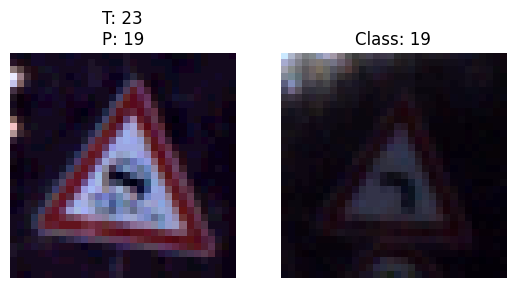

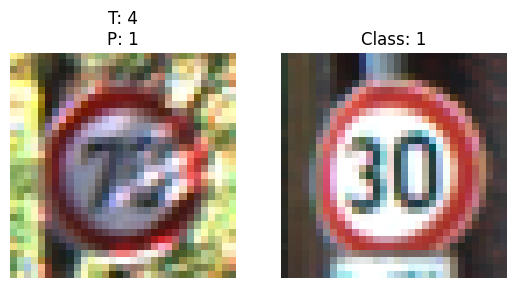

In [174]:
for i in range(min(len(incorrect_indices), num_samples - 1)):  
    index = incorrect_indices[i]
    
    plt.subplot(1, 2, 1)
    true_image_index = np.where(labels == labels[index])[0][0]
    plt.imshow(array_to_img(X_test[true_image_index]))
    plt.title(f"T: {labels[true_image_index]}\nP: {pred[index]}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    pred_image_index = np.where(labels == pred[index])[0][0]
    plt.imshow(array_to_img(X_test[pred_image_index]))
    plt.title(f"Class: {pred[index]}")
    plt.axis('off')

    plt.show()


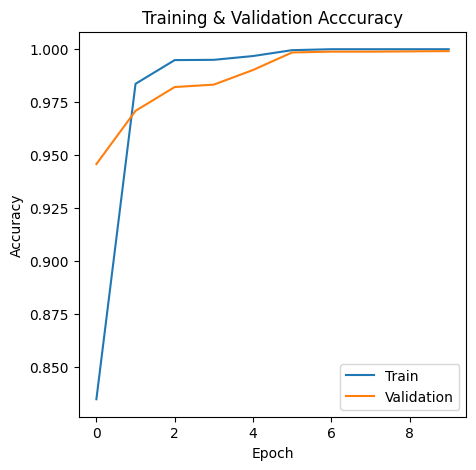

In [186]:
plt.figure(figsize=(5, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training & Validation Acccuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

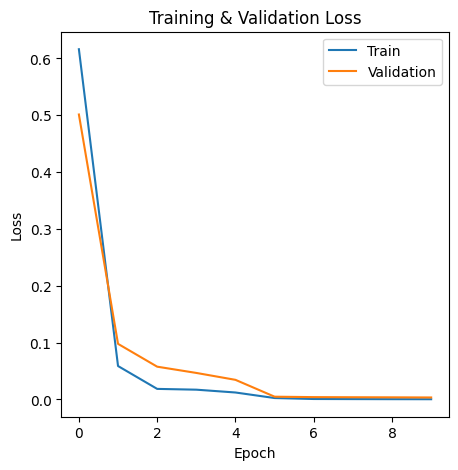

In [187]:
plt.figure(figsize=(5, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training & Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

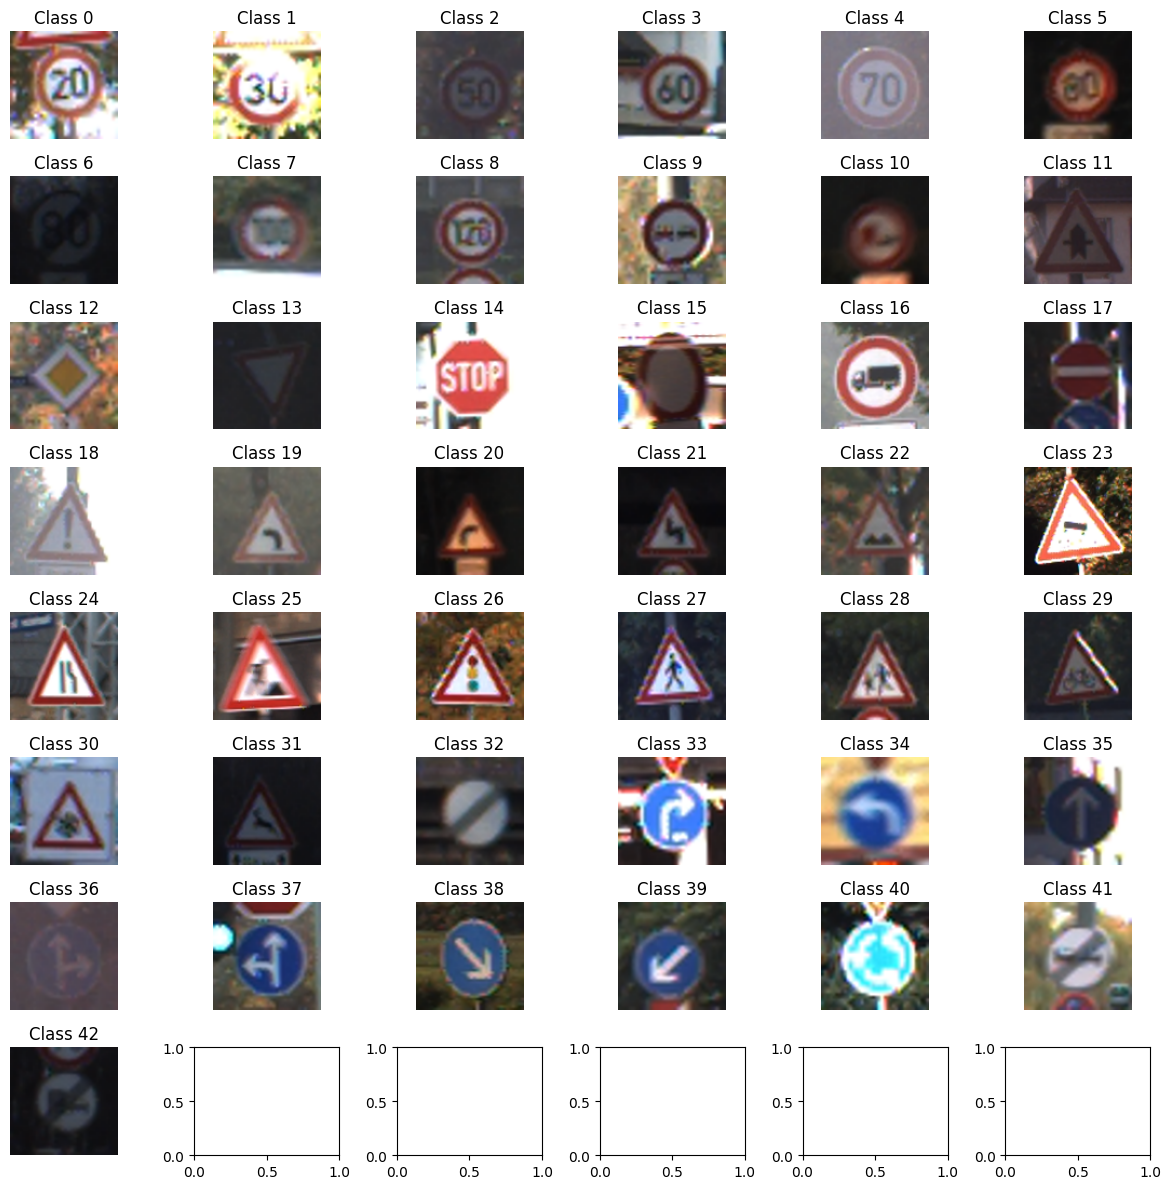

In [157]:
train_data = pd.read_csv("Train.csv")
sample_paths = []
class_ids = sorted(train_data['ClassId'].unique())

for class_id in class_ids:
    img_path = train_data[train_data['ClassId'] == class_id]['Path'].values[40]
    sample_paths.append(img_path)

# Set up a subplot grid
fig, axes = plt.subplots(8, 6, figsize=(12, 12))
axes = axes.ravel()

# Display one image for each class
for i, img_path in enumerate(sample_paths):
    if os.path.exists(img_path):
        img = Image.open(img_path)
        
        img = img.resize((100, 100)) 
        
        img_array = np.array(img)
        
        axes[i].imshow(img_array)
        axes[i].set_title(f"Class {class_ids[i]}")
        axes[i].axis('off')

plt.tight_layout()
plt.show()


The overall accuracy is 91%, which is a good starting point.
Precision, recall, and F1-score vary across classes, suggesting different levels of difficulty for the model in classifying different traffic signs.
Some classes (e.g., class 13) have perfect precision, recall, and F1-score, indicating the model performs exceptionally well on these classes.